In [72]:
from fastapi import FastAPI, File, UploadFile
from tensorflow.keras.models import load_model
import numpy as np
import cv2
from io import BytesIO
import nest_asyncio
import uvicorn

In [73]:
nest_asyncio.apply()

In [74]:
app = FastAPI()

In [75]:
absolute_path = "model_v2_1.keras"
model = load_model(absolute_path)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 255, 255, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 87)             │         5,655 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,685,991 (48.39 MB)

 Trainable params: 4,228,663 (16.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,457,328 (32.26 MB)

In [83]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(image_bytes):
    img = image.load_img(BytesIO(image_bytes), target_size=(255, 255))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0) #--shape  (1, 255, 255, 3)
    return img_array

In [78]:
# mapping
if "class_indices" in dir(model):
    gemstone_classes = {v: k for k, v in model.class_indices.items()}
else:
    gemstone_classes = {i: f"Gemstone_{i}" for i in range(87)}  

print(gemstone_classes)

{0: 'Gemstone_0', 1: 'Gemstone_1', 2: 'Gemstone_2', 3: 'Gemstone_3', 4: 'Gemstone_4', 5: 'Gemstone_5', 6: 'Gemstone_6', 7: 'Gemstone_7', 8: 'Gemstone_8', 9: 'Gemstone_9', 10: 'Gemstone_10', 11: 'Gemstone_11', 12: 'Gemstone_12', 13: 'Gemstone_13', 14: 'Gemstone_14', 15: 'Gemstone_15', 16: 'Gemstone_16', 17: 'Gemstone_17', 18: 'Gemstone_18', 19: 'Gemstone_19', 20: 'Gemstone_20', 21: 'Gemstone_21', 22: 'Gemstone_22', 23: 'Gemstone_23', 24: 'Gemstone_24', 25: 'Gemstone_25', 26: 'Gemstone_26', 27: 'Gemstone_27', 28: 'Gemstone_28', 29: 'Gemstone_29', 30: 'Gemstone_30', 31: 'Gemstone_31', 32: 'Gemstone_32', 33: 'Gemstone_33', 34: 'Gemstone_34', 35: 'Gemstone_35', 36: 'Gemstone_36', 37: 'Gemstone_37', 38: 'Gemstone_38', 39: 'Gemstone_39', 40: 'Gemstone_40', 41: 'Gemstone_41', 42: 'Gemstone_42', 43: 'Gemstone_43', 44: 'Gemstone_44', 45: 'Gemstone_45', 46: 'Gemstone_46', 47: 'Gemstone_47', 48: 'Gemstone_48', 49: 'Gemstone_49', 50: 'Gemstone_50', 51: 'Gemstone_51', 52: 'Gemstone_52', 53: 'Gemston

In [79]:
import json

json_path = "/home/vinodha/code/CptSAmerica/Space_Gem/notebooks/gemstone_classes.json"

with open(json_path, "r") as f:
    gemstone_classes = json.load(f)

print(gemstone_classes)

['Alexandrite', 'Almandine', 'Amazonite', 'Amber', 'Amethyst', 'Ametrine', 'Andalusite', 'Andradite', 'Aquamarine', 'Aventurine Green', 'Aventurine Yellow', 'Benitoite', 'Beryl Golden', 'Bixbite', 'Bloodstone', 'Blue Lace Agate', 'Carnelian', 'Cats Eye', 'Chalcedony', 'Chalcedony Blue', 'Chrome Diopside', 'Chrysoberyl', 'Chrysocolla', 'Chrysoprase', 'Citrine', 'Coral', 'Danburite', 'Diamond', 'Diaspore', 'Dumortierite', 'Emerald', 'Fluorite', 'Garnet Red', 'Goshenite', 'Grossular', 'Hessonite', 'Hiddenite', 'Iolite', 'Jade', 'Jasper', 'Kunzite', 'Kyanite', 'Labradorite', 'Lapis Lazuli', 'Larimar', 'Malachite', 'Moonstone', 'Morganite', 'Onyx Black', 'Onyx Green', 'Onyx Red', 'Opal', 'Pearl', 'Peridot', 'Prehnite', 'Pyrite', 'Pyrope', 'Quartz Beer', 'Quartz Lemon', 'Quartz Rose', 'Quartz Rutilated', 'Quartz Smoky', 'Rhodochrosite', 'Rhodolite', 'Rhodonite', 'Ruby', 'Sapphire Blue', 'Sapphire Pink', 'Sapphire Purple', 'Sapphire Yellow', 'Scapolite', 'Serpentine', 'Sodalite', 'Spessartite

In [81]:
# test preprocessing and prediction

#from tensorflow.keras.preprocessing.image import load_img, img_to_array
#image = load_img('alexandrite_18.jpg')

image_path = r"/home/vinodha/code/CptSAmerica/Space_Gem/notebooks/alexandrite_18.jpg"  
with open(image_path, "rb") as img_file:
    image_bytes = img_file.read()


processed_image = preprocess_image(image_bytes)
print(f"Processed image shape: {processed_image.shape}")


prediction = model.predict(processed_image)
predicted_class_index = np.argmax(prediction[0])
print(f"Predicted class index: {predicted_class_index}")
predicted_label = get_gemstone_label(predicted_class_index)
print(f"Predicted Gemstone: {predicted_label}")

Processed image shape: (1, 255, 255, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Predicted class index: 84
Predicted Gemstone: Variscite


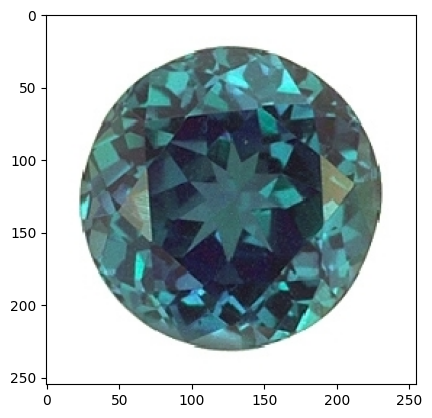

In [84]:
import matplotlib.pyplot  as plt

plt.imshow(processed_image[0], cmap='gray')

In [86]:
def get_gemstone_label(image_path):
    with open(image_path, "rb") as img_file:
        image_bytes = img_file.read()
        

SyntaxError: incomplete input (1906359177.py, line 1)

In [85]:
@app.post("/predict/")
async def predict(file: UploadFile = File(...)):
    img = preprocess_image(await file.read())  
    prediction = model.predict(img)  
    predicted_class_index = np.argmax(prediction[0])  
    predicted_class_name = gemstone_classes[str(predicted_class_index)]  
    return {"predicted_gemstone": predicted_class_name}  